# Newsvendor Intro Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

### Example 1: Intro example, max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

We formulate the Newsvendor problem with this framework, where we solve
\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \tau\\
		\text{subject to} & k^Tx  + \max\{-p^Tx,- p^Tu\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& x \geq 0.
	\end{array}
\end{equation}

In [18]:
# Formulate constants
n = 2
N = 1000
test_perc = 0.9

def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.4],[-0.3,0.1]])
    mu = np.array((0.9,0.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train


# Generate data
data = gen_demand_intro(N, seed=8)

In [24]:
num_instances = 8
p_data = []
k_data = []
for instance in range(num_instances):
  np.random.seed(instance+1)
  p_data.append(np.random.uniform(2,6,n))
  k_data.append(p_data[-1] + np.random.uniform(2,4,n))
p_data = np.array(p_data)
k_data = np.array(k_data)

# p_data = np.random.uniform(2,6,(num_instances,n))
# k_data = p_data + np.random.uniform(2,4,(num_instances,n))
# # p_data = p + np.random.normal(0,1,(num_instances,n))
# # k_data = k + np.random.normal(0,1,(num_instances,n))

In [27]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.Parameter(2, data=k_data)
p = lropt.Parameter(2, data=p_data)

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

def f_tch(t,x_r,k,p,u):
    return t
def g_tch(t,x_r,k,p,u):
    return torch.maximum(k@x_r - p@x_r, k@x_r - p@u) - t
def eval_tch(t,x_r,k,p,u):
    return torch.maximum(k@x_r - p@x_r, k@x_r - p@u)


prob = lropt.RobustProblem(objective, constraints, f_tch, [g_tch], eval_tch)
target = -0.05
s = 13


# setup intial A, b
train, test = train_test_split(data, test_size=int(data.shape[0]*test_perc), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)

# Train A and b
result_train = prob.train(lr = 0.0007, step_y = 0.01, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_lam = 0.05, target_cvar = target, init_alpha = -0.1, test_percentage = test_perc, batch_percentage=1.0)
df_train = result_train.df
A_train = result_train.A
b_train = result_train.b

# result3 = prob.train(eps = True, lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha  =-0.1, test_percentage = test_perc,scenarios = scenarios, num_instances = num_instances,max_inner_iter = 1)
# df_r2 = result3.df

In [28]:
# Grid search standard
result4 = prob.grid(epslst = np.linspace(0.01, 2.98, 100), init_A = init, init_b = init_bval, seed = s, init_alpha = -0., test_percentage = test_perc)
dfgrid = result4.df

# Grid search reshaped
result5 = prob.grid(epslst = np.linspace(0.01, 2.98, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = -0., test_percentage = test_perc)
dfgrid2 = result5.df

In [29]:
epslst = np.linspace(0.01, 2.98, 100)
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())

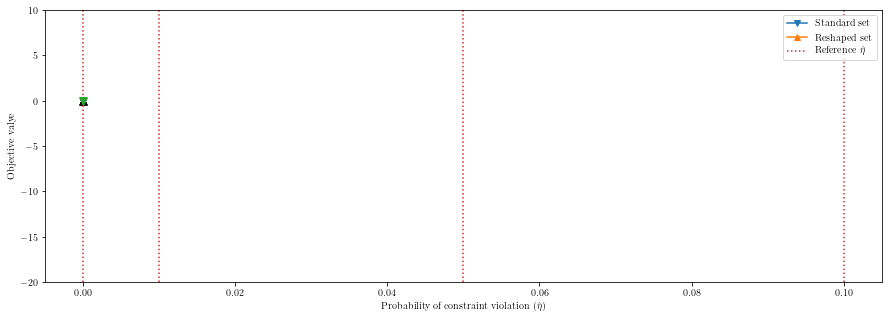

In [30]:
eps_list = np.linspace(0.01, 2.98, 80)

plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[:], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violations']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Violations']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Test_val']),0.75,axis = 1)[::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    # plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds_standard[ind]],2)), # this is the text
    #               (np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]]), # these are the coordinates to position the label
    #               textcoords="offset points", # how to position the text
    #               xytext=(5,3), # distance from text to points (x,y)
    #               ha='left',color="tab:green",fontsize=15) 

plt.plot(np.mean(np.vstack(dfgrid2['Violations']),axis = 1),np.mean(np.vstack(dfgrid2['Test_val']),axis = 1), color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violations']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Violations']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Test_val']),0.75,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
for ind in [0,2,1,3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]], color="black", s = 50, marker = "^")
    # plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds_reshaped[ind]],2)), # this is the text
    #               (np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]]), # these are the coordinates to position the label
    #               textcoords="offset points", # how to position the text
    #               xytext=(5,1), # distance from text to points (x,y)
    #               ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
#plt.xscale("log")
plt.ylim([-20,10])
plt.vlines(ymin = -20, ymax= 10, x = prob_list[0], linestyles=":", color = "tab:red", label = "Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin = -20, ymax= 10, x = i, linestyles=":", color = "tab:red")

plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves_orig.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


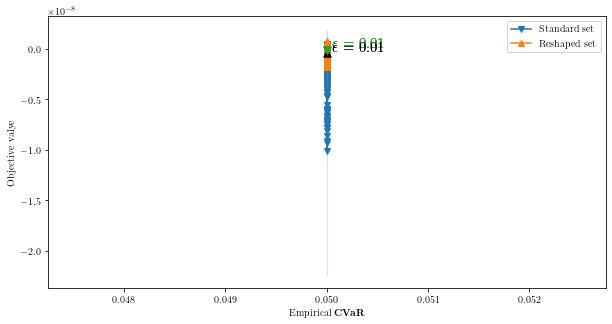

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violation_val']),axis = 1)[:], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violation_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid['Violation_val']),0.9,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid['Test_val']),0.90,axis = 1)[::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violation_val']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds_standard[ind]],2)), # this is the text
                  (np.mean(np.vstack(dfgrid['Violation_val']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(np.mean(np.vstack(dfgrid2['Violation_val']),axis = 1),np.mean(np.vstack(dfgrid2['Test_val']),axis = 1), color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violation_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid2['Violation_val']),0.9,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid2['Test_val']),0.90,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
for ind in [1,3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violation_val']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds_reshaped[ind]],2)), # this is the text
                  (np.mean(np.vstack(dfgrid2['Violation_val']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
# plt.ylim([-50,70])
plt.xlabel("Empirical $\mathbf{CVaR}$")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_cvar.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [38]:
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(num_instances):
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_standard[ind]])*init, b = (1/eps_list[inds_standard[ind]])*init_bval))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = k_data[scene]
        p = p_data[scene]
        # y = cp.Variable()

        objective = cp.Minimize(t)

        constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
        # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x_r.value

        t_base[ind][scene] = t.value

        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_reshaped[ind]])*A_fin, b = (1/eps_list[inds_reshaped[ind]])*b_fin))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = k_data[scene]
        p = p_data[scene]
        # y = cp.Variable()

        objective = cp.Minimize(t)

        constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
        # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x_r.value

        t_learned[ind][scene] = t.value
        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[1.62730016, 0.42997596],
        [0.80958556, 1.84201448]]),
 array([-1.70328934, -2.90230705]),
 array([[0.40917277, 0.18430826],
        [0.18430826, 1.06212202]]),
 array([-1.70328934, -2.90230704]))

In [39]:
K =1
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(num_instances):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
                
            for scene in range(num_instances):
                g_level_learned[ind][scene][i,j] = np.maximum(k_data[scene] @ x_opt_learned[ind][scene] - p_data[scene] @ x_opt_learned[ind][scene],k_data[scene] @ x_opt_learned[ind][scene] - p_data[scene] @ u_vec) - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] = np.maximum(k_data[scene]@ x_opt_base[ind][scene] - p_data[scene] @ x_opt_base[ind][scene], k_data[scene]@ x_opt_base[ind][scene] - p_data[scene] @ u_vec) - t_base[ind][scene]

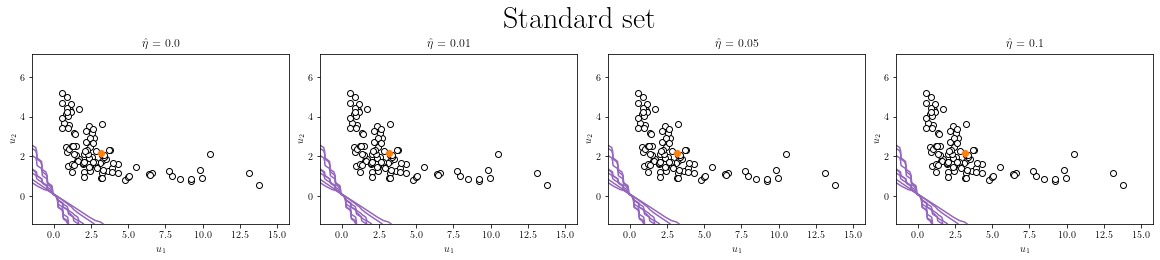

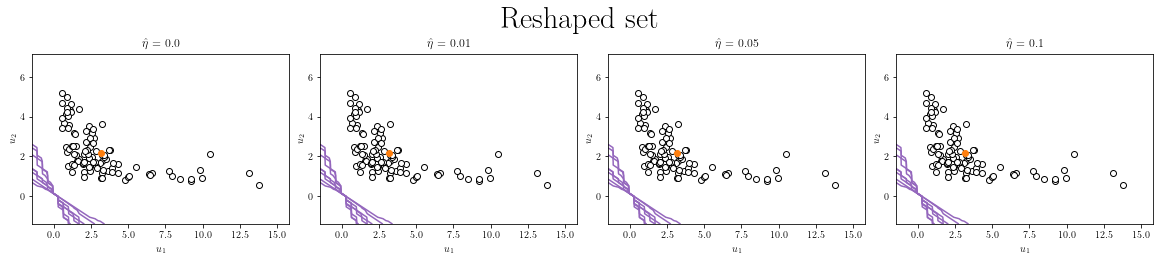

In [40]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_instances,train, "news_intro",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_instances,train, "news_intro",standard = False)